In [106]:
# Import libraries
import os
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Paths to datasets
train_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\train"
valid_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\valid"
test_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\test"
model_save_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\best_model_vgg.keras"

In [107]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [108]:
# Rescaling for validation and testing
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 4921 images belonging to 5 classes.
Found 542 images belonging to 5 classes.
Found 559 images belonging to 5 classes.


In [109]:
# Load pre-trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [110]:
from tensorflow.keras.regularizers import l2


# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu',kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu',kernel_regularizer=l2(0.0001))(x)
x = Dropout(0.3)(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

In [111]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=model_save_path, monitor='val_loss', save_best_only=True)

In [112]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop, model_checkpoint]
)

c:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 443s 6s/step - accuracy: 0.2617 - loss: 1.6795 - val_accuracy: 0.3321 - val_loss: 1.5919
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 442s 6s/step - accuracy: 0.4575 - loss: 1.4253 - val_accuracy: 0.3542 - val_loss: 1.5456
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step - accuracy: 0.5599 - loss: 1.1983 - val_accuracy: 0.4114 - val_loss: 1.5741
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 441s 6s/step - accuracy: 0.6189 - loss: 1.0656 - val_accuracy: 0.4262 - val_loss: 1.5639
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 442s 6s/step - accuracy: 0.6653 - loss: 0.9526 - val_accuracy: 0.4114 - val_loss: 1.5218
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 442s 6s/step - accuracy: 0.6721 - loss: 0.9060 - val_accuracy: 0.4539 - val_loss: 1.4957
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 444s 6s/step - accuracy: 0.7148 - loss: 0.8404 - val_accuracy: 0.4594 - val_loss: 1.5042
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 445s 6s/step - accuracy: 0.7164 - loss: 0.8058 - val_accuracy: 0.4760 - v

In [113]:
# Fine-tuning: Unfreeze top layers of VGG16
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [120]:
# Continue training with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 519s 7s/step - accuracy: 0.9043 - loss: 0.3274 - val_accuracy: 0.6568 - val_loss: 1.1669
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 512s 7s/step - accuracy: 0.9084 - loss: 0.3089 - val_accuracy: 0.6162 - val_loss: 1.3986
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 512s 7s/step - accuracy: 0.9123 - loss: 0.3019 - val_accuracy: 0.6144 - val_loss: 1.3644
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 513s 7s/step - accuracy: 0.9254 - loss: 0.2830 - val_accuracy: 0.6624 - val_loss: 1.1945
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 511s 7s/step - accuracy: 0.9315 - loss: 0.2561 - val_accuracy: 0.6402 - val_loss: 1.3767


In [121]:
model.save(r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\final_model_vgg.h5")

In [122]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.6948 - loss: 0.9508
Test Accuracy: 65.65%
Test Loss: 1.0613


In [123]:
# Classification Report and Confusion Matrix
test_preds = model.predict(test_generator)
test_pred_classes = np.argmax(test_preds, axis=1)
true_classes = test_generator.classes
class_labels = list(train_generator.class_indices.keys())

# Classification Report
print(classification_report(true_classes, test_pred_classes, target_names=class_labels))

9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 5s/step
              precision    recall  f1-score   support

  Botol Kaca       0.84      0.74      0.79       134
      Kaleng       0.74      0.82      0.78       112
      Kardus       0.58      0.62      0.60        61
      Kertas       0.53      0.40      0.45       126
     Plastik       0.56      0.70      0.62       126

    accuracy                           0.66       559
   macro avg       0.65      0.66      0.65       559
weighted avg       0.66      0.66      0.65       559



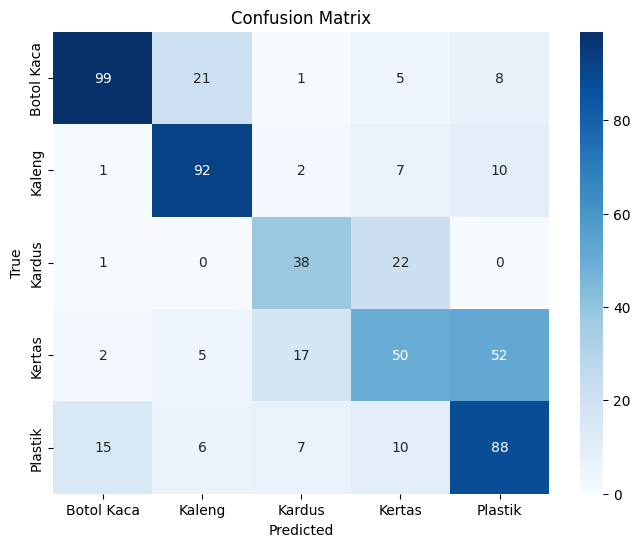

In [124]:
# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, test_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

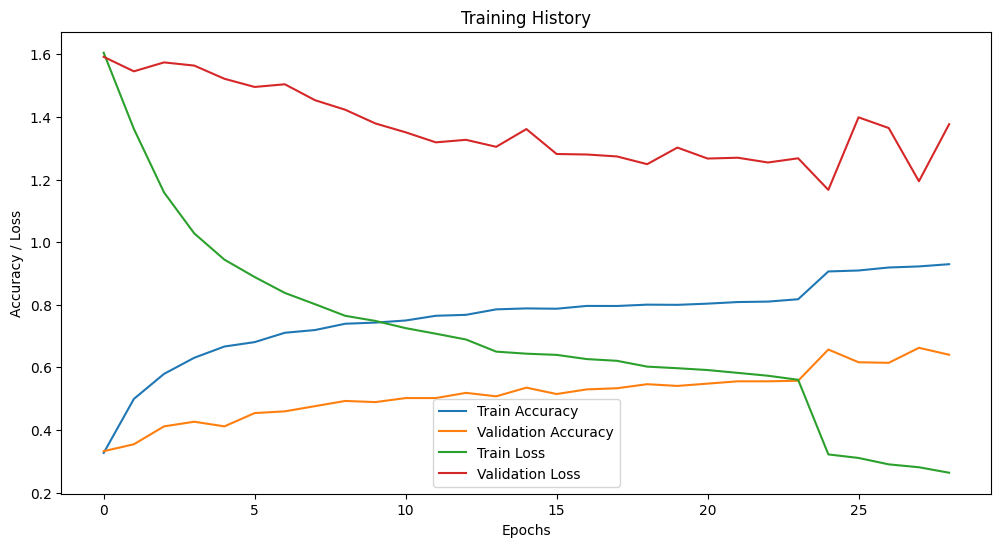

In [125]:
# Visualization of training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step


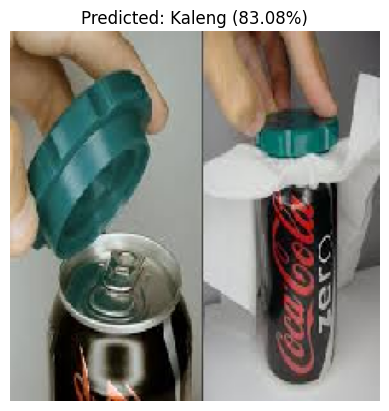

In [129]:
# Predict a single image
def predict_image(image_path, model, class_labels):
    img = load_img(image_path, target_size=(224, 224))  # Resize image
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions for batch
    
    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction) * 100
    
    # Display the image and prediction
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.show()

# Example: Predict a single image
test_image_path = r"C:\Users\Nana Casmana\Downloads\Garbage Classification-20241121T105258Z-001\Garbage Classification\newdataset\test\Kaleng\R_2040.jpg"
predict_image(test_image_path, model, class_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step


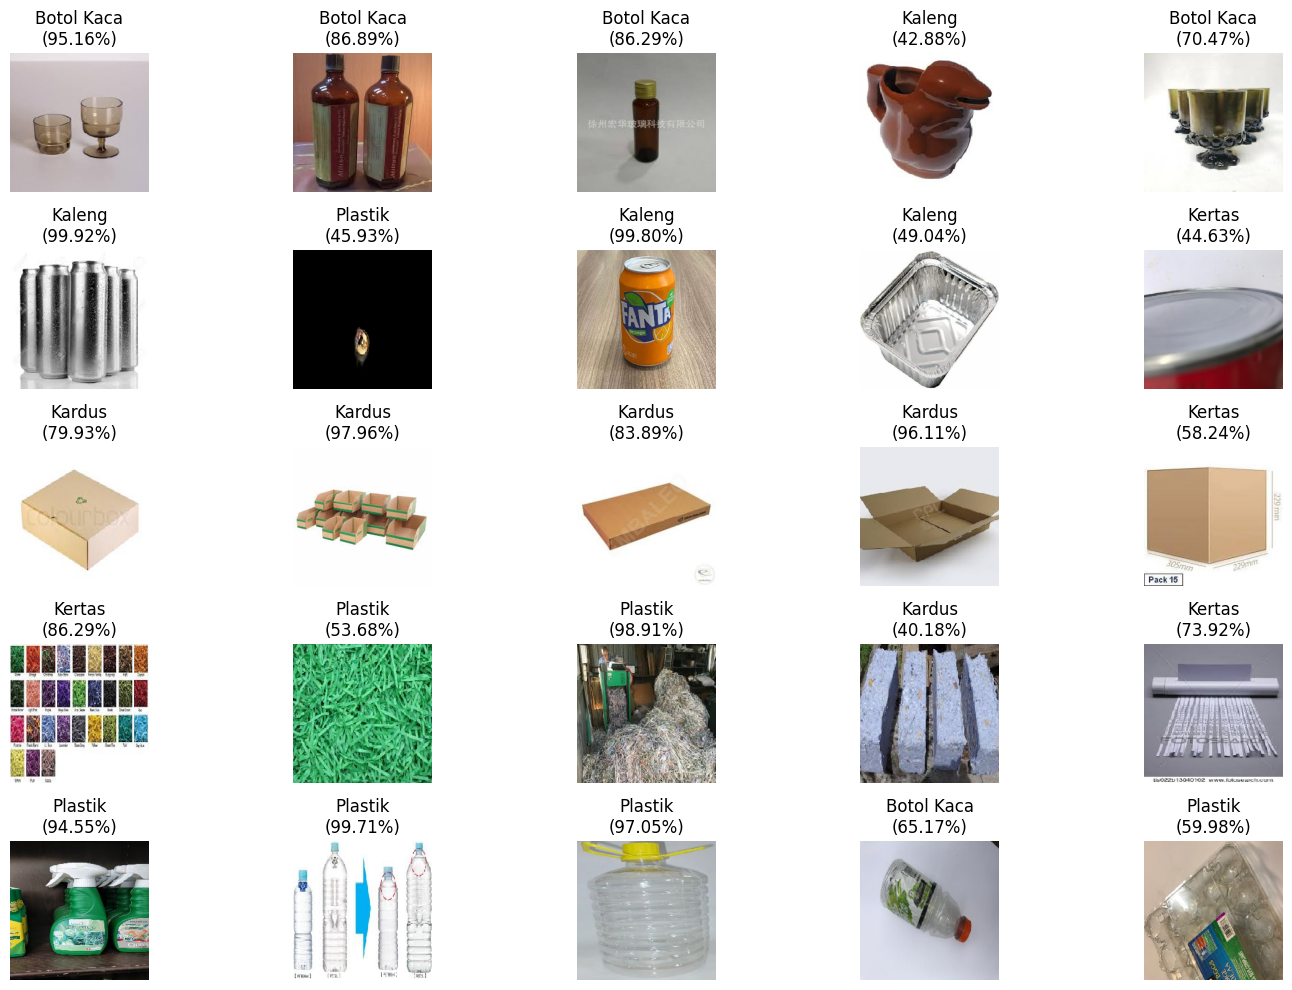

In [127]:
# Predict batch of images
def predict_batch_images(test_path, model, class_labels, num_images=5):
    test_categories = os.listdir(test_path)
    plt.figure(figsize=(15, 10))
    
    count = 0
    for category in test_categories:
        category_path = os.path.join(test_path, category)
        images = os.listdir(category_path)[:num_images]
        
        for image_name in images:
            img_path = os.path.join(category_path, image_name)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Predict
            prediction = model.predict(img_array)
            predicted_class = class_labels[np.argmax(prediction)]
            confidence = np.max(prediction) * 100
            
            # Display the image and prediction
            plt.subplot(len(test_categories), num_images, count + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{predicted_class}\n({confidence:.2f}%)")
            count += 1
    plt.tight_layout()
    plt.show()

# Example: Predict a batch of images
predict_batch_images(test_path, model, class_labels, num_images=5)
